1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.).

2. Для задачи классификации обучить дерево решений с использованием критериев разбиения Джини и Энтропия. Сравнить качество классификации, сделать выводы.

3 [опция]. Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

In [298]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [299]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=5)

In [300]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

classification_train_data, classification_test_data, classification_train_labels, classification_test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

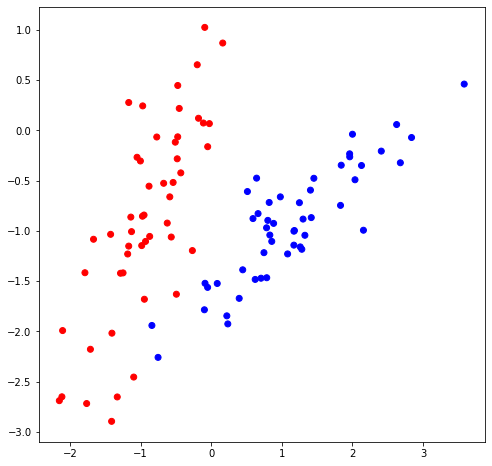

In [301]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [302]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [303]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction      

In [304]:
class Tree:
    def __init__(self,
                 max_depth=None, 
                 criterion='gini', 
                 min_samples_leaf=1, 
                 min_samples_split = 2):
        
        self.max_depth = max_depth
        self.min_leaf = min_samples_leaf
        self.min_samples_split = min_samples_split
        if criterion == 'gini' or criterion == 'entropy':
            self.criterion = criterion
        else:
            raise Exception('Неверно выбран критерий информативности')
        self._tree = None

      # Расчет качества

    def quality(self, left_labels, right_labels, current_criteria):

        if self.criterion == 'entropy':
                # доля выбоки, ушедшая в левое поддерево
            p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

            return current_criteria - p * self.entropy(left_labels) - (1 - p) * self.entropy(right_labels)

        else:
                # доля выбоки, ушедшая в левое поддерево
            p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

            return current_criteria - p * self.gini(left_labels) - (1 - p) * self.gini(right_labels)

            
        
    def gini(self, labels):
            #  подсчет количества объектов разных классов
        classes = {}
        for label in labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1

            #  расчет критерия
        impurity = 1
        for label in classes:
            p = classes[label] / len(labels)
            impurity -= p ** 2

        return impurity

        # Расчет Энтропии

    def entropy(self, labels):
            #  подсчет количества объектов разных классов
        classes = {}
        for label in labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1

            #  расчет критерия
        impurity = 0
        for label in classes:
            p = classes[label] / len(labels)
            impurity -= p * np.log2(p)

        return impurity

    # Разбиение датасета в узле

    def split(self, data, labels, index, t):

        left = np.where(data[:, index] <= t)
        right = np.where(data[:, index] > t)

        true_data = data[left]
        false_data = data[right]
        true_labels = labels[left]
        false_labels = labels[right]

        return true_data, false_data, true_labels, false_labels

    # Нахождение наилучшего разбиения

    def find_best_split(self, data, labels):

        if self.criterion == 'entropy':
            current_criteria = self.entropy(labels)
        else: 
            current_criteria = self.gini(labels)


        best_quality = 0
        best_t = None
        best_index = None

        n_features = data.shape[1]

        for index in range(n_features):
            # будем проверять только уникальные значения признака, исключая повторения
            t_values = np.unique([row[index] for row in data])

            for t in t_values:
                true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)
                #  пропускаем разбиения, в которых в узле остается менее 5 объектов
                if len(true_data) < self.min_leaf or len(false_data) < self.min_leaf:
                    continue
                    
                current_quality = self.quality(true_labels, false_labels, current_criteria)

                #  выбираем порог, на котором получается максимальный прирост качества
                if current_quality > best_quality:
                    best_quality, best_t, best_index = current_quality, t, index

        return best_quality, best_t, best_index

    # Построение дерева с помощью рекурсивной функции

# Построение дерева с помощью рекурсивной функции

    def build_tree(self, data, labels, tree_depth):

        quality, t, index = self.find_best_split(data, labels)

        #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
        if quality == 0:
            return Leaf(data, labels)

        if self.max_depth and tree_depth >= self.max_depth:
            return Leaf(data, labels)

        if len(data) <= self.min_samples_split:
            return Leaf(data, labels)

        tree_depth += 1

        true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)

        # Рекурсивно строим два поддерева
        true_branch = self.build_tree(true_data, true_labels, tree_depth)
        false_branch = self.build_tree(false_data, false_labels, tree_depth)

        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
        return Node(index, t, true_branch, false_branch)

    def classify_object(self, obj, node):

    #  Останавливаем рекурсию, если достигли листа
        if isinstance(node, Leaf):
            answer = node.prediction
            return answer

        if obj[node.index] <= node.t:
            return self.classify_object(obj, node.true_branch)
        else:
            return self.classify_object(obj, node.false_branch)

    def predict(self, data):

        classes = []
        for obj in data:
            prediction = self.classify_object(obj, self._tree)
            classes.append(prediction)
        return classes
    
        # Напечатаем ход нашего дерева

    def _print_tree(self, node, spacing=""):

        # Если лист, то выводим его прогноз
        if isinstance(node, Leaf):
            print(spacing + "Прогноз:", node.prediction)
            return

        # Выведем значение индекса и порога на этом узле
        print(spacing + 'Индекс', str(node.index))
        print(spacing + 'Порог', str(node.t))

        # Рекурсионный вызов функции на положительном поддереве
        print (spacing + '--> True:')
        self._print_tree(node.true_branch, spacing + "  ")

        # Рекурсионный вызов функции на положительном поддереве
        print (spacing + '--> False:')
        self._print_tree(node.false_branch, spacing + "  ")
        
    def print_tree(self):
        return self._print_tree(self._tree)
    

    def fit(self, data, labels):
        self._tree = self.build_tree(data, labels, 0)
        return self

In [306]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [305]:
tree = Tree(max_depth=5, criterion='entropy', min_samples_leaf = 1, min_samples_split = 2)
tree.fit(classification_train_data, classification_train_labels)

In [242]:
tree.print_tree()

Индекс 0
Порог 0.16261402870113306
--> True:
  Индекс 1
  Порог -1.5208896621663803
  --> True:
    Индекс 0
    Порог -0.9478301462477035
    --> True:
      Прогноз: 0
    --> False:
      Индекс 0
      Порог -0.4942656820712277
      --> True:
        Прогноз: 1
      --> False:
        Прогноз: 1
  --> False:
    Прогноз: 0
--> False:
  Прогноз: 1


In [310]:
tree_gini = Tree(max_depth=50, criterion='gini', min_samples_leaf = 1, min_samples_split = 2)
tree_gini.fit(classification_train_data, classification_train_labels)

In [311]:
tree_gini.print_tree()

Индекс 0
Порог 0.16261402870113306
--> True:
  Индекс 1
  Порог -1.5208896621663803
  --> True:
    Индекс 0
    Порог -0.9478301462477035
    --> True:
      Прогноз: 0
    --> False:
      Индекс 0
      Порог -0.4942656820712277
      --> True:
        Прогноз: 1
      --> False:
        Прогноз: 1
  --> False:
    Прогноз: 0
--> False:
  Прогноз: 1


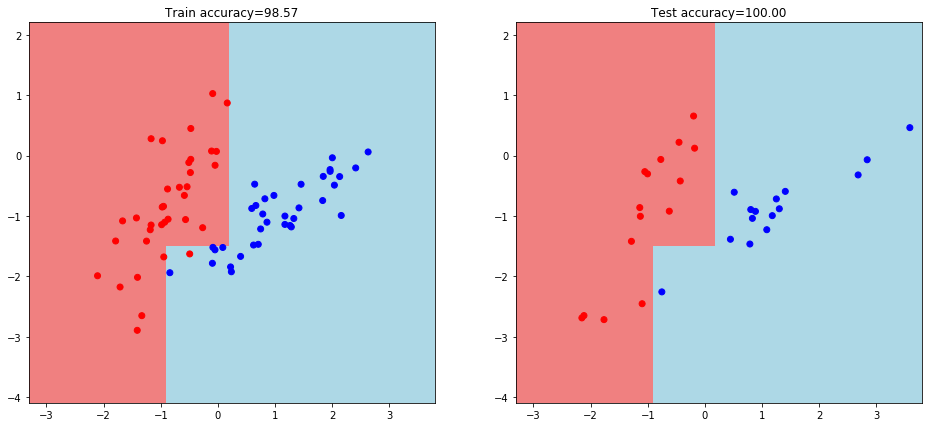

In [314]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
def train_graf(train_data, train_labels, test_data, test_labels, tree):
    train_accuracy = accuracy_metric(train_labels, tree.predict(train_data))
    test_accuracy = accuracy_metric(test_labels, tree.predict(test_data))
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(tree.predict(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')
    

# график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')
# train_graf(classification_train_data, classification_train_labels, classification_test_data, classification_test_labels, tree_gini)
train_graf(classification_train_data, classification_train_labels, classification_test_data, classification_test_labels, tree)

In [331]:
# Получим ответы для обучающей выборки 
train_answers = tree_gini.predict(classification_train_data)

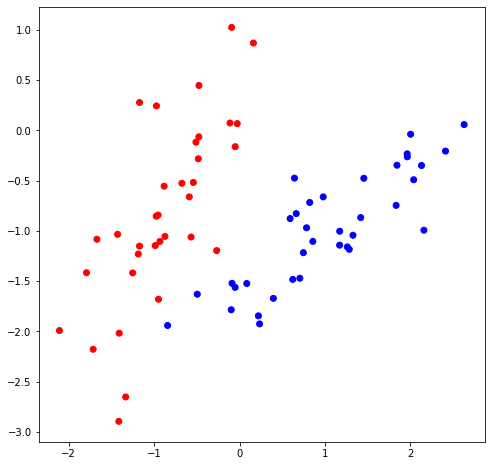

In [332]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_train_data)), list(map(lambda x: x[1], classification_train_data)), 
              c=train_answers, cmap=colors)

In [61]:
class RegressionLeaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        prediction = np.mean(self.labels)
        return prediction

In [250]:
class RegressionTree(Tree):
    
    def quality(self, left_labels, right_labels, current_criteria):
        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
        return current_criteria - p * self.dispersion(left_labels) - (1 - p) * self.dispersion(right_labels)

      # Дисперсия значений      
        
    def dispersion(self, labels):
        return np.std(labels)

    def find_best_split(self, data, labels):

        current_criteria = self.dispersion(labels)


        best_quality = 0
        best_t = None
        best_index = None

        n_features = data.shape[1]

        for index in range(n_features):
            # будем проверять только уникальные значения признака, исключая повторения
            t_values = np.unique([row[index] for row in data])

            for t in t_values:
                true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)
                #  пропускаем разбиения, в которых в узле остается менее 5 объектов
                if len(true_data) < self.min_leaf or len(false_data) < self.min_leaf:
                    continue
                    
                current_quality = self.quality(true_labels, false_labels, current_criteria)

                #  выбираем порог, на котором получается максимальный прирост качества
                if current_quality > best_quality:
                    best_quality, best_t, best_index = current_quality, t, index

        return best_quality, best_t, best_index
    
    def build_tree(self, data, labels, tree_depth):

        quality, t, index = self.find_best_split(data, labels)

        #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
        if quality == 0:
            return RegressionLeaf(data, labels)

        if self.max_depth and tree_depth >= self.max_depth:
            return RegressionLeaf(data, labels)

        if len(data) <= self.min_samples_split:
            return RegressionLeaf(data, labels)

        tree_depth += 1

        true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)

        # Рекурсивно строим два поддерева
        true_branch = self.build_tree(true_data, true_labels, tree_depth)
        false_branch = self.build_tree(false_data, false_labels, tree_depth)

        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
        return Node(index, t, true_branch, false_branch)

    def classify_object(self, obj, node):

        #  Останавливаем рекурсию, если достигли листа
        if isinstance(node, RegressionLeaf):
            answer = node.prediction
            return answer

        if obj[node.index] <= node.t:
            return self.classify_object(obj, node.true_branch)
        else:
            return self.classify_object(obj, node.false_branch)

    
        # Напечатаем ход нашего дерева

    def _print_tree(self, node, spacing=""):

        # Если лист, то выводим его прогноз
        if isinstance(node, RegressionLeaf):
            print(spacing + "Прогноз:", node.prediction)
            return

        # Выведем значение индекса и порога на этом узле
        print(spacing + 'Индекс', str(node.index))
        print(spacing + 'Порог', str(node.t))

        # Рекурсионный вызов функции на положительном поддереве
        print (spacing + '--> True:')
        self._print_tree(node.true_branch, spacing + "  ")

        # Рекурсионный вызов функции на положительном поддереве
        print (spacing + '--> False:')
        self._print_tree(node.false_branch, spacing + "  ")
        
    def print_tree(self):
        return self._print_tree(self._tree)

In [275]:
data, target, coef = datasets.make_regression(n_samples=1000, n_features = 2, n_informative = 2, n_targets = 1, 
                                              noise = 2, coef = True, random_state = 2)

In [276]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(data, 
                                                                                     target, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [326]:
tree_regression = RegressionTree(max_depth=50, min_samples_leaf = 1, min_samples_split = 2)
tree_regression.fit(train_data, train_labels)

In [327]:
test_answers2 = tree_regression.predict(test_data)

In [323]:
train_answers2 = tree_regression.predict(train_data)

In [279]:
tree_regression.print_tree()

Индекс 1
Порог 0.26448360406258725
--> True:
  Индекс 0
  Порог 0.132924055186507
  --> True:
    Индекс 1
    Порог -1.1648113258867563
    --> True:
      Индекс 0
      Порог -1.8532888650882562
      --> True:
        Индекс 0
        Порог -2.2000219885513803
        --> True:
          Индекс 0
          Порог -3.136547096243239
          --> True:
            Прогноз: -324.1367685304956
          --> False:
            Индекс 0
            Порог -2.515439456144192
            --> True:
              Прогноз: -260.2863359284602
            --> False:
              Прогноз: -280.5334168438868
        --> False:
          Индекс 1
          Порог -1.5466746112644163
          --> True:
            Прогноз: -231.365715460462
          --> False:
            Прогноз: -216.9539076597356
      --> False:
        Индекс 1
        Порог -1.7934355851948631
        --> True:
          Индекс 1
          Порог -3.326870107456545
          --> True:
            Прогноз: -272.0337293856739
 

In [317]:
# реализуем функцию, определяющую среднеквадратичную ошибку
def mserror(y, y_pred):
    return np.mean(np.square(y - y_pred))

In [328]:
mserror(test_labels, test_answers2)

155.41485570936948

In [329]:
mserror(train_labels, train_answers2)

5.068638010979736

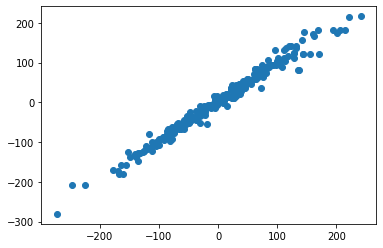

In [291]:
plt.scatter(test_labels, test_answers2)

plt.show()